<a href="https://colab.research.google.com/github/RawanKhaled20/AgeDetection/blob/main/AgeDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rawankhaled20","key":"f5a17aecb67ca4675b425dadbe4ab60e"}'}

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [13]:
!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv

 77% 49.0M/63.2M [00:00<00:00, 167MB/s]
100% 63.2M/63.2M [00:00<00:00, 167MB/s]


In [14]:
! unzip age-gender-and-ethnicity-face-data-csv.zip

Archive:  age-gender-and-ethnicity-face-data-csv.zip
  inflating: age_gender.csv          


In [7]:
!pip install scikit-plot
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [49]:
df = pd.read_csv('/content/age_gender.csv')
print(df.shape)
df.head()


(23705, 5)


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [36]:
df.age.unique()

array([  1,  10, 100, 101, 103, 105,  11, 110, 111, 115, 116,  12,  13,
        14,  15,  16,  17,  18,  19,   2,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,   3,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,   4,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
         5,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,   6,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,   7,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,   8,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,   9,  90,  91,  92,  93,  95,  96,  99])

In [50]:
# Define the classify_age function
def classify_age(age):
    if age <= 17:
        return '0'
    elif age <= 40:
        return '1'
    else:
        return '2'

# Apply the classify_age function to classify ages into categories and create a new column 'Category2'
df['Category2'] = df['age'].apply(classify_age)

# Check the DataFrame with the new column
print(df)

       age  ethnicity  gender                        img_name  \
0        1          2       0  20161219203650636.jpg.chip.jpg   
1        1          2       0  20161219222752047.jpg.chip.jpg   
2        1          2       0  20161219222832191.jpg.chip.jpg   
3        1          2       0  20161220144911423.jpg.chip.jpg   
4        1          2       0  20161220144914327.jpg.chip.jpg   
...    ...        ...     ...                             ...   
23700   99          0       1  20170120221920654.jpg.chip.jpg   
23701   99          1       1  20170120134639935.jpg.chip.jpg   
23702   99          2       1  20170110182418864.jpg.chip.jpg   
23703   99          2       1  20170117195405372.jpg.chip.jpg   
23704   99          0       1  20170110182052119.jpg.chip.jpg   

                                                  pixels Category2  
0      129 128 128 126 127 130 133 135 139 142 145 14...         0  
1      164 74 111 168 169 171 175 182 184 188 193 199...         0  
2      67 70

In [41]:
age_label_to_text = { 0:'Young', 1:'Middle', 2:'Old' }

In [51]:
df.Category2.value_counts()

1    12766
2     6706
0     4233
Name: Category2, dtype: int64

In [43]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

In [47]:
INTERESTED_LABELS = [0,1,2]
print(df.head())

   age  ethnicity  gender                        img_name  \
0    1          2       0  20161219203650636.jpg.chip.jpg   
1    1          2       0  20161219222752047.jpg.chip.jpg   
2    1          2       0  20161219222832191.jpg.chip.jpg   
3    1          2       0  20161220144911423.jpg.chip.jpg   
4    1          2       0  20161220144914327.jpg.chip.jpg   

                                              pixels Category2  
0  129 128 128 126 127 130 133 135 139 142 145 14...         0  
1  164 74 111 168 169 171 175 182 184 188 193 199...         0  
2  67 70 71 70 69 67 70 79 90 103 116 132 145 155...         0  
3  193 197 198 200 199 200 202 203 204 205 208 21...         0  
4  202 205 209 210 209 209 210 211 212 214 218 21...         0  


In [53]:
# Assuming INTERESTED_LABELS contains the labels you're interested in (0, 1, 2)
INTERESTED_LABELS = [0, 1, 2]

# Filter the DataFrame to include only rows where "Category2" column is in INTERESTED_LABELS
filtered_df = df['Category2'].isin(INTERESTED_LABELS)

# Check the shape of the filtered DataFrame
print(filtered_df.shape)

(23705,)


In [54]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [55]:
img_array.shape

(23705, 48, 48, 1)

In [56]:
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()
img_labels = le.fit_transform(df.Category2)
img_labels = to_categorical(img_labels)
img_labels.shape

(23705, 3)

In [57]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'0': 0, '1': 1, '2': 2}


In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((21334, 48, 48, 1), (2371, 48, 48, 1), (21334, 3), (2371, 3))

In [59]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]

In [60]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [61]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            3,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

In [62]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [63]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [64]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1])
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

<ipython-input-64-b39dcc308b2a>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
666/666 [==============================] - 37s 40ms/step - loss: 1.0610 - accuracy: 0.5525 - val_loss: 0.7267 - val_accuracy: 0.6913 - lr: 0.0010
Epoch 2/100
666/666 [==============================] - 23s 34ms/step - loss: 0.7051 - accuracy: 0.6983 - val_loss: 0.6338 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 3/100
666/666 [==============================] - 23s 34ms/step - loss: 0.6118 - accuracy: 0.7463 - val_loss: 0.5463 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 4/100
666/666 [==============================] - 23s 34ms/step - loss: 0.5680 - accuracy: 0.7685 - val_loss: 0.4335 - val_accuracy: 0.8288 - lr: 0.0010
Epoch 5/100
666/666 [==============================] - 23s 34ms/step - loss: 0.5375 - accuracy: 0.7847 - val_loss: 0.8523 - val_accuracy: 0.7094 - lr: 0.0010
Epoch 6/100
666/666 [==============================] - 23s 34ms/step - loss: 0.5112 - accuracy: 0.7973 - val_loss: 0.5774 - val_accuracy: 0.8106 - lr: 0.0010
Epoch 7/100
666/666 [==============================]

In [70]:
model.save("mode55.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
mapper = {
    0: "Young",
    1: "Middle",
    2: 'Old',
}

1/1 [==============================] - 0s 100ms/step


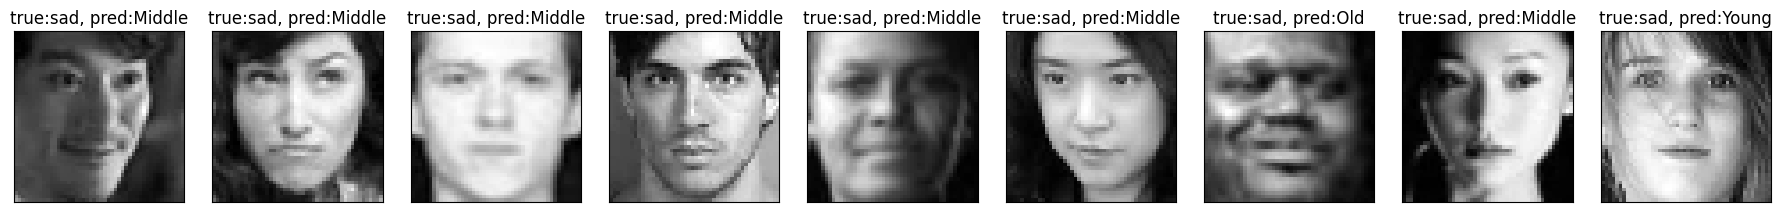

In [66]:
import numpy as np
from matplotlib import pyplot

np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1] == 1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, sadidx in enumerate(random_sad_imgs):
    ax = pyplot.subplot(2, 9, i + 1)
    sample_img = X_valid[sadidx, :, :, 0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    # Reshape sample_img to match model's input shape
    sample_img_reshaped = sample_img.reshape(1, 48, 48, 1)

    # Get model predictions
    predictions = model.predict(sample_img_reshaped)

    # Get predicted class index
    predicted_class_index = np.argmax(predictions)

    # Get emotion label using predicted class index
    predicted_emotion = mapper[predicted_class_index]

    ax.set_title(f"true:sad, pred:{predicted_emotion}")

# Moved outside the loop
pyplot.tight_layout()
pyplot.show()

1/1 [==============================] - 0s 19ms/step


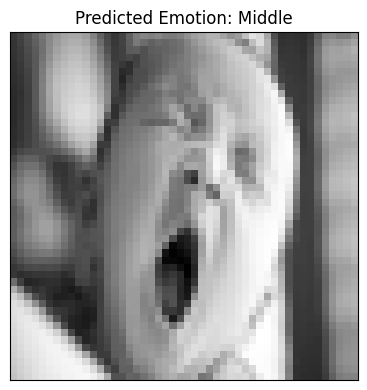

In [69]:
import numpy as np
from matplotlib import pyplot
from PIL import Image

# Assuming 'mapper' is a dictionary mapping class indices to emotion labels
# You need to define 'mapper' based on your specific mapping

# Assuming 'model' is your trained model

# Load and preprocess your input image
input_image_path = "/content/yawning.jpg"  # Specify the path to your input image
input_image = Image.open(input_image_path).convert("L")  # Open the image and convert to grayscale
input_image = input_image.resize((48, 48))  # Resize the image to match your model's input shape
input_image_array = np.array(input_image)  # Convert the image to a numpy array
input_image_array = input_image_array / 255.0  # Normalize the pixel values (assuming pixel range 0-255)
input_image_array = input_image_array.reshape(1, 48, 48, 1)  # Reshape the array to match model's input shape

# Make predictions using your model
predictions = model.predict(input_image_array)

# Get predicted class index
predicted_class_index = np.argmax(predictions)

# Get emotion label using predicted class index
predicted_emotion = mapper[predicted_class_index]

# Visualize the input image and predicted emotion
fig = pyplot.figure(1, (6, 4))  # Adjust figure size as needed
ax = pyplot.subplot(1, 1, 1)  # Adjust subplot parameters for single image
ax.imshow(input_image_array[0, :, :, 0], cmap='gray')  # Display the input image
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(f"Predicted Emotion: {predicted_emotion}")

# Adjust layout and display the plot
pyplot.tight_layout()
pyplot.show()
